# TensorFlow

TensorFlow is yet open source another deep learning framework that is widely used for building and training models. Below is an implementation of a PINN that attempts to slove the 1D Poisson Equation using TensorFlow.


We aim to solve the following **1D Poisson equation** on the domain $( x \in (0, 1) \$:

$$
\frac{d^2u}{dx^2} = -\pi^2 \sin(\pi x)
$$

This equation arises frequently in physics and engineering problems involving heat flow, electrostatics, and structural mechanics.

---

##  Boundary Conditions

We impose **Dirichlet boundary conditions**:

$$
u(0) = 0, \quad u(1) = 0
$$

These conditions constrain the solution to be zero at both ends of the interval.

---
##  Exact Solution

The exact analytical solution is:

$$
u(x) = \sin(\pi x)
$$

This solution will be used to verify the correctness of the PINN.

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# generate points to compute the physics loss
x_physics_loss = tf.constant(np.linspace(0, 1, 100).reshape(-1,1),dtype=tf.float32)
# define the boundary conditions to compute the boundary loss
x_boundary_loss = tf.constant([[0.0],[1.0]])
y_boundary_loss = tf.constant([[0.0],[0.0]])

# points from the exact solution for comparision
x_exact = tf.constant(np.linspace(0, 1, 100).reshape(-1,1),dtype=tf.float32)
y_exact = tf.sin(np.pi*x_exact)

In [11]:
# defining the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(50, activation='tanh'),
    tf.keras.layers.Dense(50, activation='tanh'),
    tf.keras.layers.Dense(1, activation='linear')
])

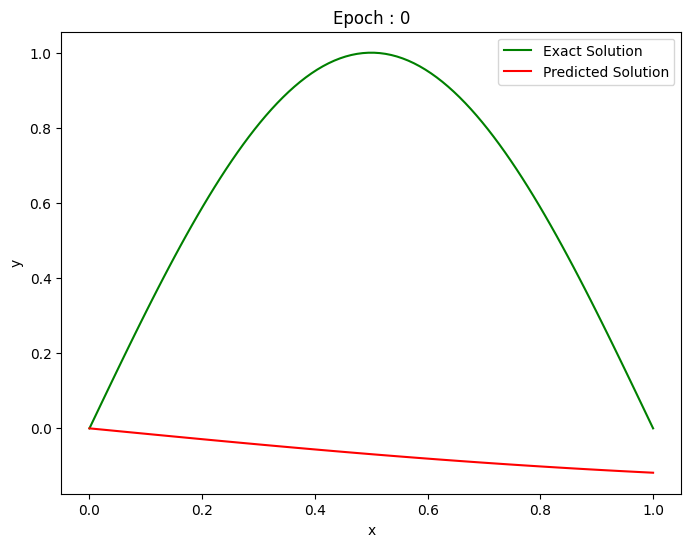

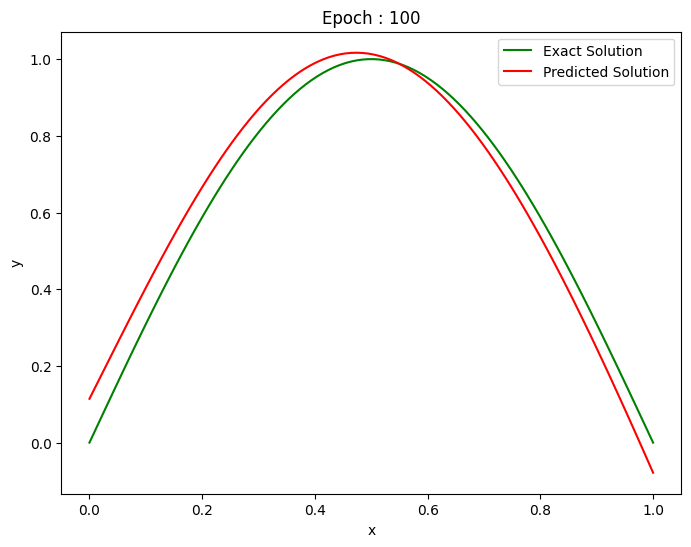

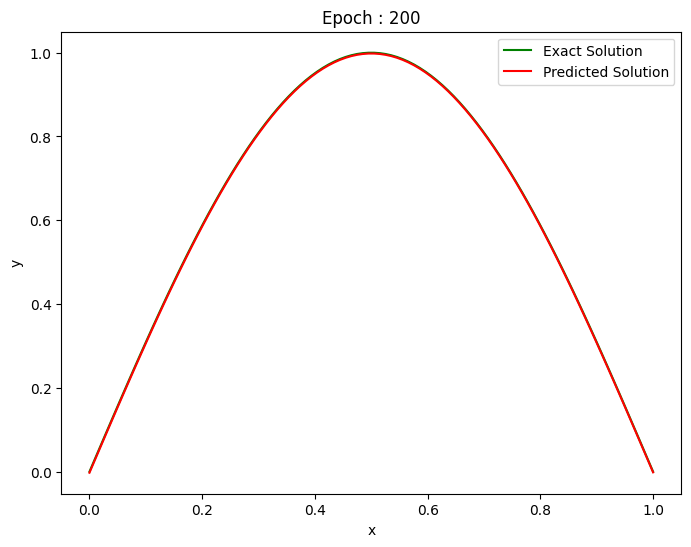

In [12]:
tf.random.set_seed(42)

epochs = 201
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

for epoch in range(epochs):

  # computing loss
  with tf.GradientTape(persistent=True) as tape:

    tape.watch(x_physics_loss)      # required if input is created using tf.constant
    tape.watch(x_boundary_loss)

    y_pred_physics = model(x_physics_loss)
    y_pred_boundary = model(x_boundary_loss)

    dy_dx = tape.gradient(y_pred_physics, x_physics_loss)
    d2y_dx2 = tape.gradient(dy_dx, x_physics_loss)

    physics_loss = tf.reduce_mean((d2y_dx2 + np.pi**2 * tf.sin(np.pi*x_physics_loss))**2)
    boundary_loss = tf.reduce_mean((y_pred_boundary - y_boundary_loss)**2)
    total_loss = physics_loss + boundary_loss

  # calculating and passing the gradients to the optimizer along with the parameters
  gradients = tape.gradient(total_loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  if not epoch % 100:
    plt.figure(figsize=(8, 6))
    plt.plot(x_exact, y_exact, color='green', label='Exact Solution')
    plt.plot(x_physics_loss, y_pred_physics, color='red', label='Predicted Solution')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Epoch : {epoch}')
    plt.legend()
    plt.show()

